SRC: cloth3d++_subset/
Number of data used to train:
59928
Input shape: (2, 256, 256, 3)
Label shape: (2, 256, 256)
Learning rate: 1e-07
Epoch 1/12
  14982/Unknown - 2378s 157ms/step - loss: 0.0059 - mae: 0.0394

2024-05-27 00:55:51.346384: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 16569504095248563035
2024-05-27 00:55:51.346424: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 2548887854972656661
2024-05-27 00:55:51.346431: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous recv item cancelled. Key hash: 12272699694009900839
/home/alberto/anaconda3/envs/tf3dcloth/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14982/14982 [==============================] - 2489s 165ms/step - loss: 0.0059 - mae: 0.0394 - val_loss: 0.0061 - val_mae: 0.0288
Epoch 2/12
14982/14982 [==============================] - 2470s 165ms/step - loss: 0.0026 - mae: 0.0191 - val_loss: 0.0059 - val_mae: 0.0263
Epoch 3/12
14982/14982 [==============================] - 2472s 165ms/step - loss: 0.0021 - mae: 0.0163 - val_loss: 0.0054 - val_mae: 0.0251
Epoch 4/12
14982/14982 [==============================] - 2470s 165ms/step - loss: 0.0018 - mae: 0.0146 - val_loss: 0.0058 - val_mae: 0.0254
Epoch 5/12
14982/14982 [==============================] - 2473s 165ms/step - loss: 0.0016 - mae: 0.0135 - val_loss: 0.0057 - val_mae: 0.0246
Epoch 6/12
14982/14982 [==============================] - 2474s 165ms/step - loss: 0.0014 - mae: 0.0127 - val_loss: 0.0050 - val_mae: 0.0229
Epoch 7/12
14982/14982 [==============================] - 2474s 165ms/step - loss: 0.0013 - mae: 0.0120 - val_loss: 0.0048 - val_mae: 0.0223
Epoch 8/12
14982/14982 [

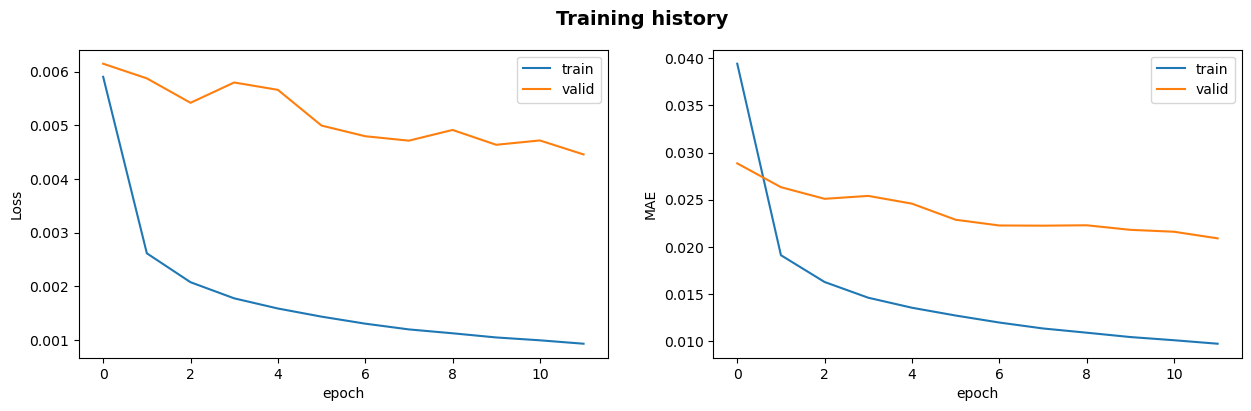

Best validation loss: 0.004457799252122641 at epoch 11


In [2]:

import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
import os
from PIL import Image
import tensorflow_addons as tfa



# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

n_epochs = 20
batch_size = 2

# %%
class TFRecordDataHandler:
    def __init__(self, tfrecord_file, batch_size=32, shuffle=True, augment=False):
        self.tfrecord_file = tfrecord_file
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

    def _parse_function(self, proto):
        feature_description = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'depth': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'depth_height': tf.io.FixedLenFeature([], tf.int64),
            'depth_width': tf.io.FixedLenFeature([], tf.int64)
        }
        parsed_features = tf.io.parse_single_example(proto, feature_description)

        image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
        depth = tf.io.decode_raw(parsed_features['depth'], tf.float32)

        height = parsed_features['height']
        width = parsed_features['width']

        image = tf.reshape(image, [height, width, 3])
        depth = tf.reshape(depth, [parsed_features['depth_height'], parsed_features['depth_width']])

        return image, depth

    def _normalize(self, image, depth):
        # Convert image to float for processing and normalize to range [0, 1]
        image = tf.cast(image, tf.float32) / 255.0

        # Create a mask where depth values are greater than zero
        depth_mask = depth > 0

        # Normalize depth based on masked regions
        # Calculate the mean of the depth where it is greater than zero
        depth_values = tf.boolean_mask(depth, depth_mask)
        depth_mean = tf.reduce_mean(depth_values)

        # Subtract the mean from the depth values where mask is true
        depth = tf.where(depth_mask, depth - depth_mean, depth)

        # Set depth values less than 0 to 0 after subtraction
        depth = tf.maximum(depth, 0)

        # Prepare the mask for RGB image normalization
        mask = tf.tile(tf.expand_dims(depth_mask, axis=-1), [1, 1, 3])

        # Masked image for mean and std deviation calculation
        masked_image = tf.boolean_mask(image, mask)
        mean, variance = tf.nn.moments(masked_image, axes=[0])
        std_dev = tf.sqrt(variance + 1e-6)  # Adding epsilon to avoid division by zero

        # Apply the mask to image normalization
        normalized_image = tf.where(
            mask,
            (image - mean) / std_dev,
            image  # Preserve original pixels where mask is False
        )

        return normalized_image, depth

    def _augment(self, image, depth):
        target_height, target_width = 256, 256  # Set your desired fixed shape here

        # Horizontal flip with 50% probability
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_left_right(image)
            depth = tf.image.flip_left_right(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        
        # Vertical flip with 50% probability
        if tf.random.uniform(()) > 0.5:
            image = tf.image.flip_up_down(image)
            depth = tf.image.flip_up_down(tf.expand_dims(depth, axis=-1))
            depth = tf.squeeze(depth, axis=-1)
        
        # Random rotation
        angle = tf.random.uniform([], -20, 20) * (3.14159265 / 180)  # convert degrees to radians
        image = tfa.image.rotate(image, angle)
        depth = tfa.image.rotate(tf.expand_dims(depth, axis=-1), angle)
        depth = tf.squeeze(depth, axis=-1)
        
        # Random width shift
        width_shift = tf.random.uniform([], -0.1, 0.1) * tf.cast(tf.shape(image)[1], tf.float32)
        image = tfa.image.translate(image, [width_shift, 0])
        depth = tfa.image.translate(tf.expand_dims(depth, axis=-1), [width_shift, 0])
        depth = tf.squeeze(depth, axis=-1)
        
        # Random height shift
        height_shift = tf.random.uniform([], -0.1, 0.1) * tf.cast(tf.shape(image)[0], tf.float32)
        image = tfa.image.translate(image, [0, height_shift])
        depth = tfa.image.translate(tf.expand_dims(depth, axis=-1), [0, height_shift])
        depth = tf.squeeze(depth, axis=-1)
        
        # Random zoom
        zoom_factor = tf.random.uniform([], 1 - 0.2, 1 + 0.2)
        new_size = tf.cast(tf.cast(tf.shape(image)[:2], tf.float32) * zoom_factor, tf.int32)
        image = tf.image.resize(image, new_size)
        depth = tf.image.resize(tf.expand_dims(depth, axis=-1), new_size)
        depth = tf.squeeze(depth, axis=-1)
        
        # Resize back to fixed target size
        image = tf.image.resize(image, [target_height, target_width])
        depth = tf.image.resize(tf.expand_dims(depth, axis=-1), [target_height, target_width])
        depth = tf.squeeze(depth, axis=-1)
        
        # Random brightness adjustment
        image = tf.image.random_brightness(image, max_delta=0.1)
        
        return image, depth

    def load_dataset(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        dataset = dataset.map(self._parse_function, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self._normalize, num_parallel_calls=tf.data.AUTOTUNE)

        if self.augment:
            dataset = dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)

        if self.shuffle:
            dataset = dataset.shuffle(buffer_size=1000)

        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset
    
    def get_num_samples(self):
        dataset = tf.data.TFRecordDataset(self.tfrecord_file)
        count = 0
        for _ in dataset:
            count += 1
        return count


# %%

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        print(f"Epoch {epoch + 1}: Learning rate is {tf.keras.backend.get_value(lr):.6f}")

class TensorBoardLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir='./logs'):
        super(TensorBoardLearningRateLogger, self).__init__()
        self.file_writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        with self.file_writer.as_default():
            tf.summary.scalar('learning_rate', tf.keras.backend.get_value(lr), step=epoch)

# %%
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)


# %%
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)

        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)

        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate

        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }

# %%
# Parameters
initial_learning_rate = 1e-5
target_learning_rate = 1e-2
verbose = 1
shuffle = True
checkpoint = './best_model.h5'

trainloader = TFRecordDataHandler('train.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=True)
valloader = TFRecordDataHandler('validation.tfrecords', batch_size=batch_size, shuffle=shuffle, augment=False)
train_dg = trainloader.load_dataset()
validation_dg = valloader.load_dataset()

num_samples_train = trainloader.get_num_samples()

print('Number of data used to train:')
print(num_samples_train * batch_size)
# print('')

for x, y in train_dg.take(1):
    print("Input shape:", x.shape)  # Should be (batch_size, height, width, channels)
    print("Label shape:", y.shape)  # Should be (batch_size, ...) depending on your task


total_steps = num_samples_train // num_samples_train * n_epochs


import datetime
for wu_ratio in [0.2]:

    warmup_steps = int(wu_ratio * total_steps)

    folder_name = f'transunet_DA'
     #get the time of the experiment
    time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    experiment_name = folder_name + '_' + time
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join("logs",  experiment_name))
    tensorboard_lr_logger = TensorBoardLearningRateLogger(os.path.join("logs", experiment_name))


    # Create the learning rate schedule
    lr_schedule = WarmUpCosineDecayScheduler(
        initial_learning_rate=initial_learning_rate,
        target_learning_rate=target_learning_rate,
        total_steps=total_steps,
        warmup_steps=warmup_steps
    )

    # Define the optimizer with the custom learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

    model = models.transunet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=1,
                                stack_num_down=2, stack_num_up=1, 
                                activation='GELU', output_activation='Sigmoid',
                                batch_norm=True, pool='max', unpool=False, name='transunet_2d', embed_dim=100, num_heads=4)

    print('Learning rate:', initial_learning_rate)
    # defining the optimizer
    model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

    es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

    # saving the best model based on val_loss
    mc = tf.keras.callbacks.ModelCheckpoint(os.path.join("models", experiment_name, checkpoint), monitor='val_mae', mode='min', save_best_only=True)
    
    # training the model and saving the history (.take(10))
    history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, workers=-1, use_multiprocessing=True,
                        callbacks=[tensorboard_callback, tensorboard_lr_logger, mc, es])

    # Plot and write the history
    if not os.path.exists(experiment_name):
        os.makedirs(experiment_name)
    filename = os.path.join(experiment_name, 'train_history.jpg')
    visualize_hist(history, show=True, filename=filename)

    #with open('train_history_lr_'+str(lr)+'.pkl', 'wb') as handle:
    #    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
    # Get the best validation loss and the epoch

    best_val_loss = min(history.history['val_loss'])
    best_epoch = history.history['val_loss'].index(best_val_loss)
    # d_lr[lr] = (best_val_loss, best_epoch)
    print('Best validation loss:', best_val_loss, 'at epoch', best_epoch)

    # Clear gpu memory
    del model
    gc.collect()
    tf.keras.backend.clear_session()

# %%